In [1]:
# just some useful functions, imports and settings

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}',
    "axes.grid": True,
    "axes.grid.which": 'both',
    'grid.linewidth': '1',
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"approximation of function {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], 2*err[i])} {units}"
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

## 6a. Pseudo random number generator

#### i

In [2]:

class MyRNG:
    
    def __init__(self, m = 1 << 48, a = 25214903917, c = 11):
        self.m = m
        self.a = a
        self.c = c
        self.I = 1
        
    def rand(self):
        ''' returns random float from [0; 1)'''
        self.I = (self.a*self.I + self.c)%self.m
        return self.I/self.m
    
    

In [3]:
wiki_generator = MyRNG()
for i in range(10):
    print(wiki_generator.rand(), end='\t')
    


8.958133409464608e-05	0.7319531771219197	0.8720866053171861	0.37554806125634244	0.7943048269107607	0.3641457971656017	0.31001760917578025	0.9453565926573084	0.1565396564872117	0.5252284246314893	

#### ii Randomness checking

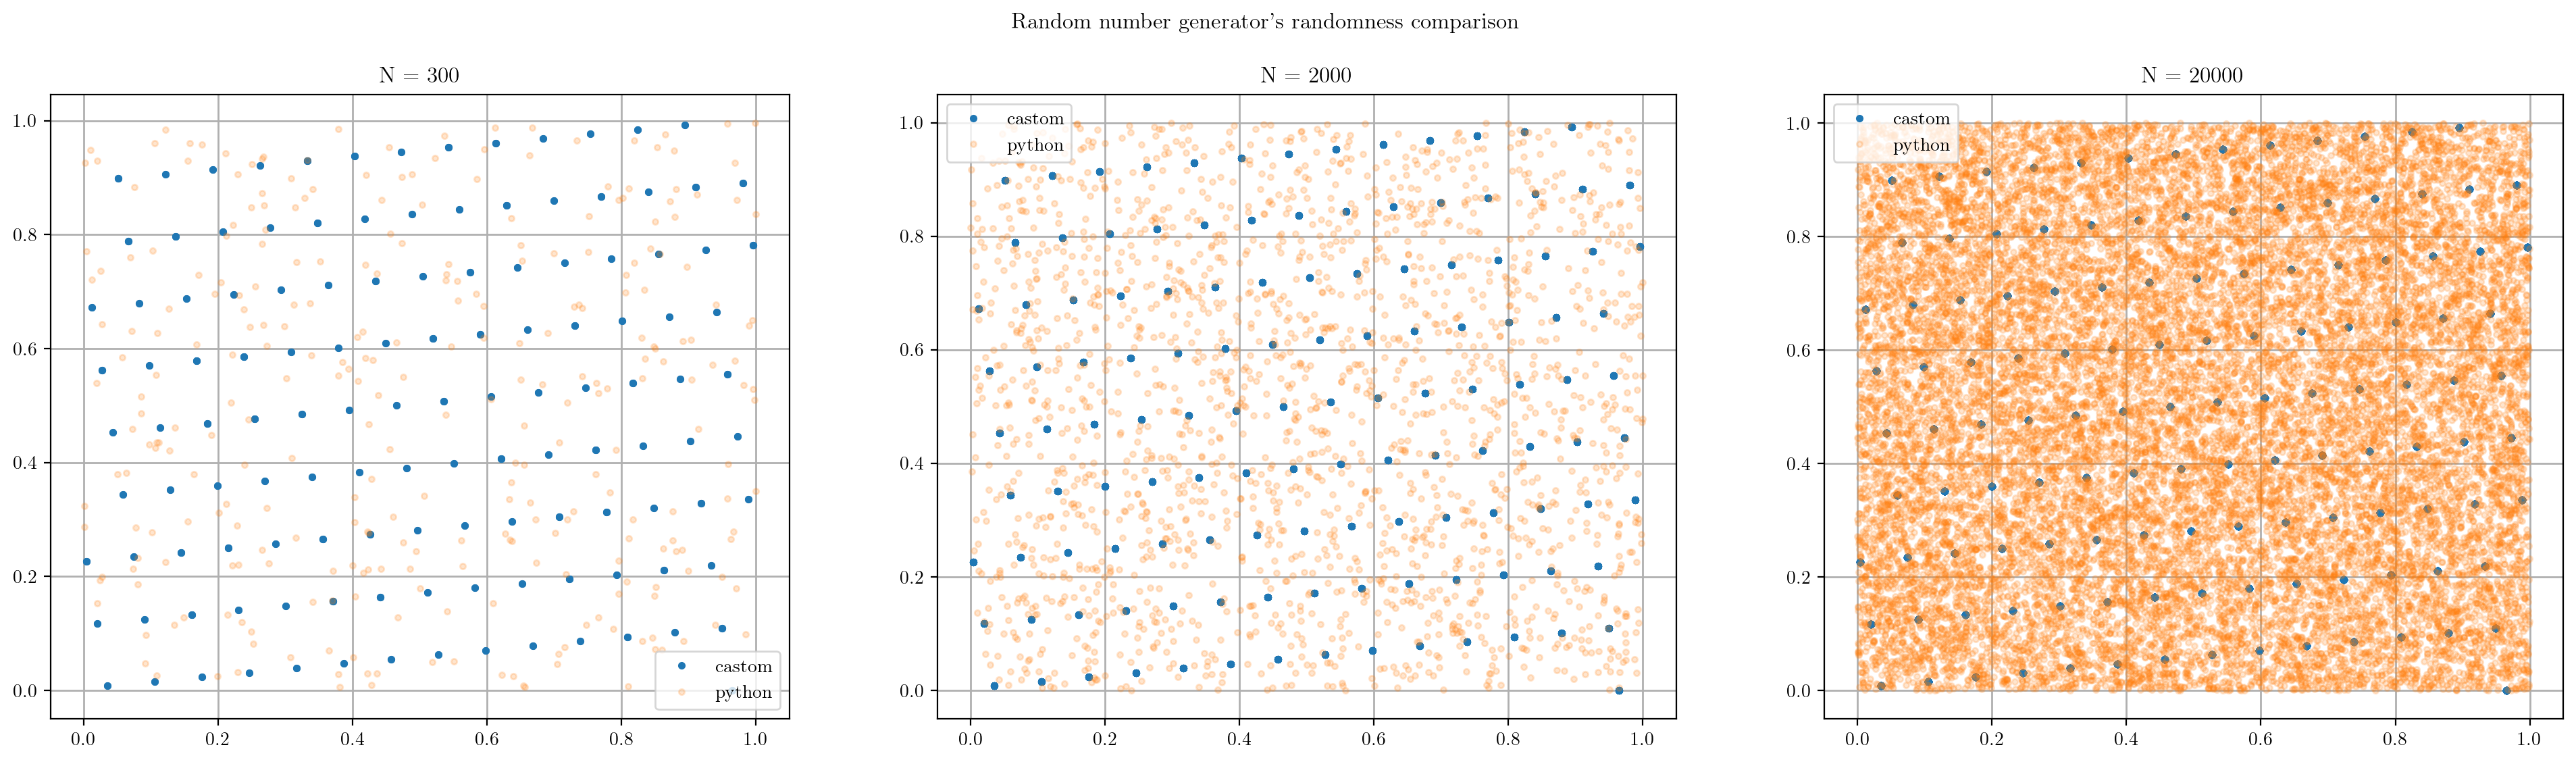

In [4]:
test_rand = MyRNG(a = 57, c = 1, m = 256)
test_rand.I = 0

import random
random.seed(42)

def generate_pairs(generator_fun, N=1000):
    x, y = [], []
    
    for _ in range(N):
        x.append(generator_fun())
        y.append(generator_fun())
    return x, y


plt.figure(figsize=(3*8, 6))
plt.suptitle("Random number generator's randomness comparison")
Ns = [300, 2000, 20_000]
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f"N = {Ns[i]}")
    x1, y1 = generate_pairs(test_rand.rand, N=Ns[i])
    plt.plot(x1, y1, '.', label='castom')

    x2, y2 = generate_pairs(random.random, N=Ns[i])
    plt.plot(x2, y2, '.', alpha=0.2, label='python')

    plt.legend()
    
plt.show()




It is clear, that our generator is very weak.

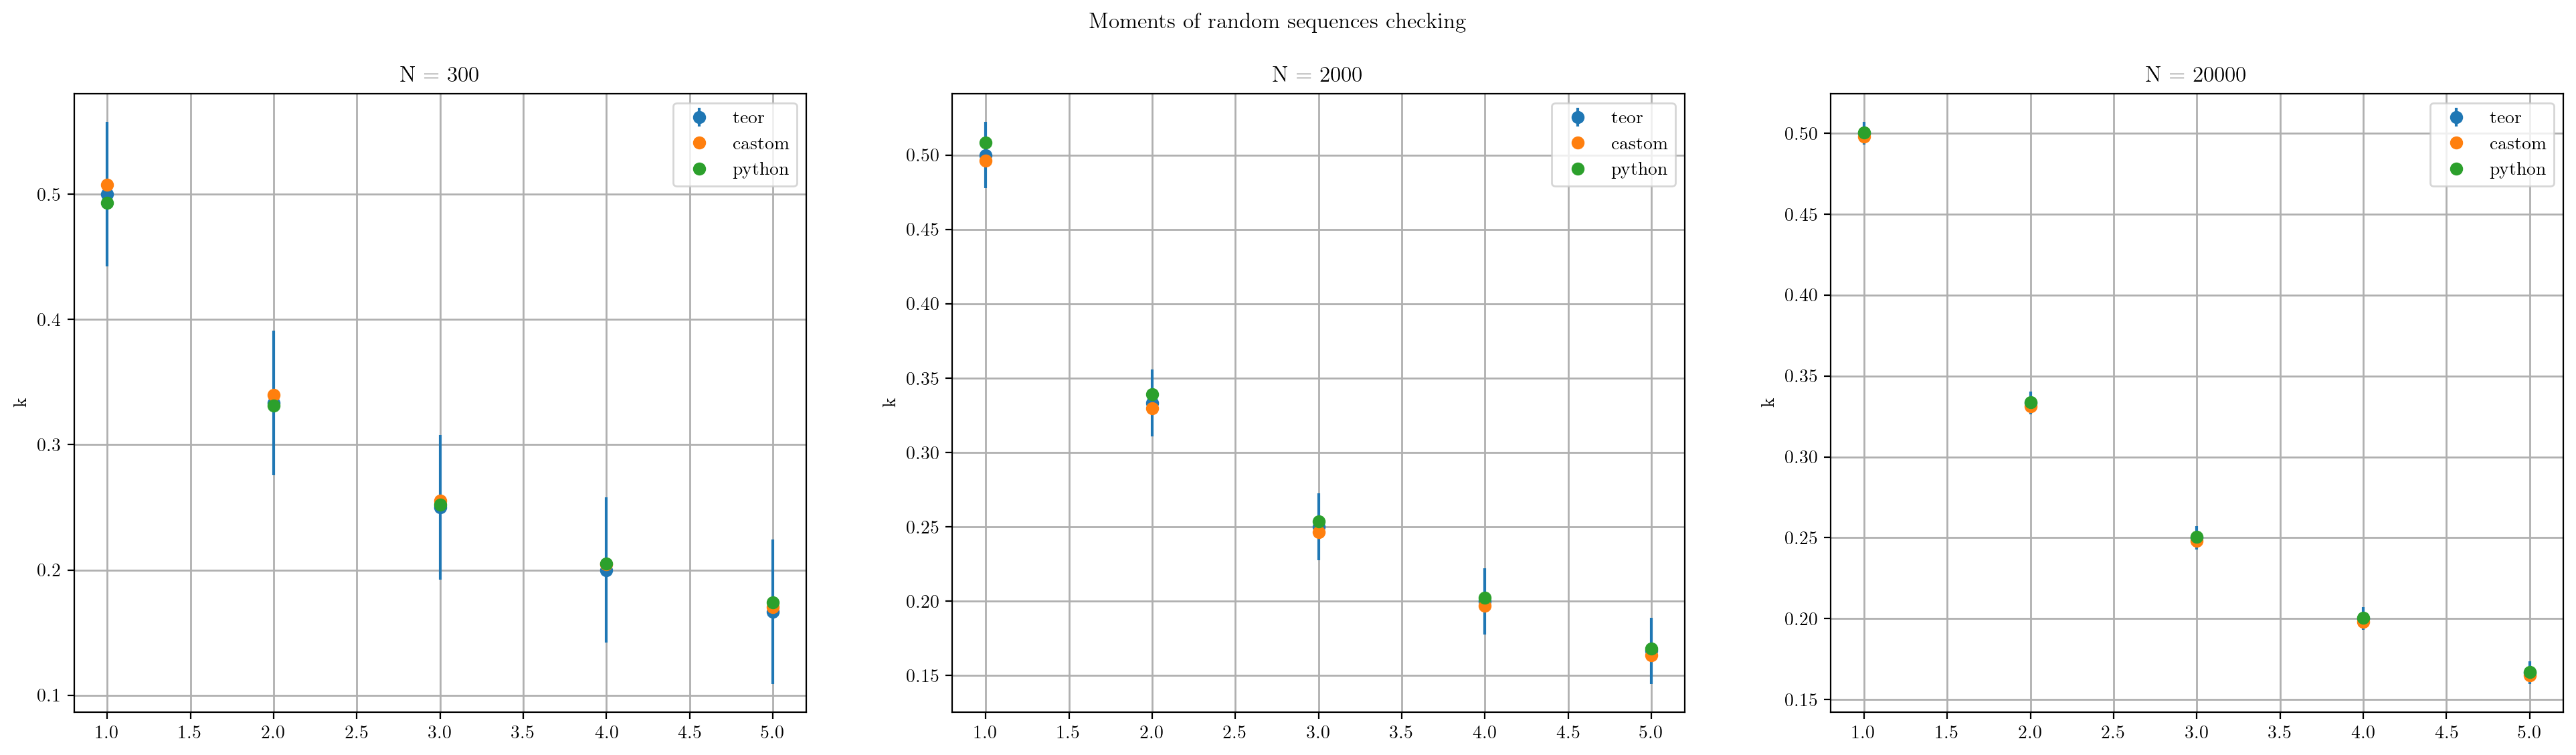

In [5]:
def generate_sequence(generator_fun, N=1000):
    x = []
    for _ in range(N):
        x.append(generator_fun())
    return np.array(x)

test_rand = MyRNG(a = 57, c = 1, m = 256)
test_rand.I = 0

import random
random.seed(42)

plt.figure(figsize=(8*3, 6))
plt.suptitle("Moments of random sequences checking")

Ns = [300, 2000, 20_000]
for i in range(3):
    N = Ns[i]
    plt.subplot(1, 3, 1+i)
    plt.title(f"N = {N}")
    plt.ylabel("$<x^k>$")
    plt.ylabel("k")
    k_s = list(range(1, 6))

    moments = []
    error = []
    for k in k_s:
        moments.append(1/(k+1))
        error.append(1/N**0.5)
    plt.errorbar(k_s, moments, fmt="o", yerr=error, label='teor')
        
    moments = []
    error = []
    rand_seq = generate_sequence(test_rand.rand, N=N)
    for k in k_s:
        x_k = rand_seq**k
        moments.append(np.mean(x_k))
        
        # standart deviation
        error.append(np.sqrt(np.mean(np.square(x_k.mean() - x_k))))  
    plt.errorbar(k_s, moments, fmt="o", label='castom')
        
        
    moments = []
    error = []
    rand_seq = generate_sequence(random.random, N=N)
    for k in k_s:
        x_k = rand_seq**k
        moments.append(np.mean(x_k))
        
        # standart deviation
        error.append(np.sqrt(np.mean(np.square(x_k.mean() - x_k))))  
    plt.errorbar(k_s, moments, fmt="o", label='python')
        
    plt.legend()    


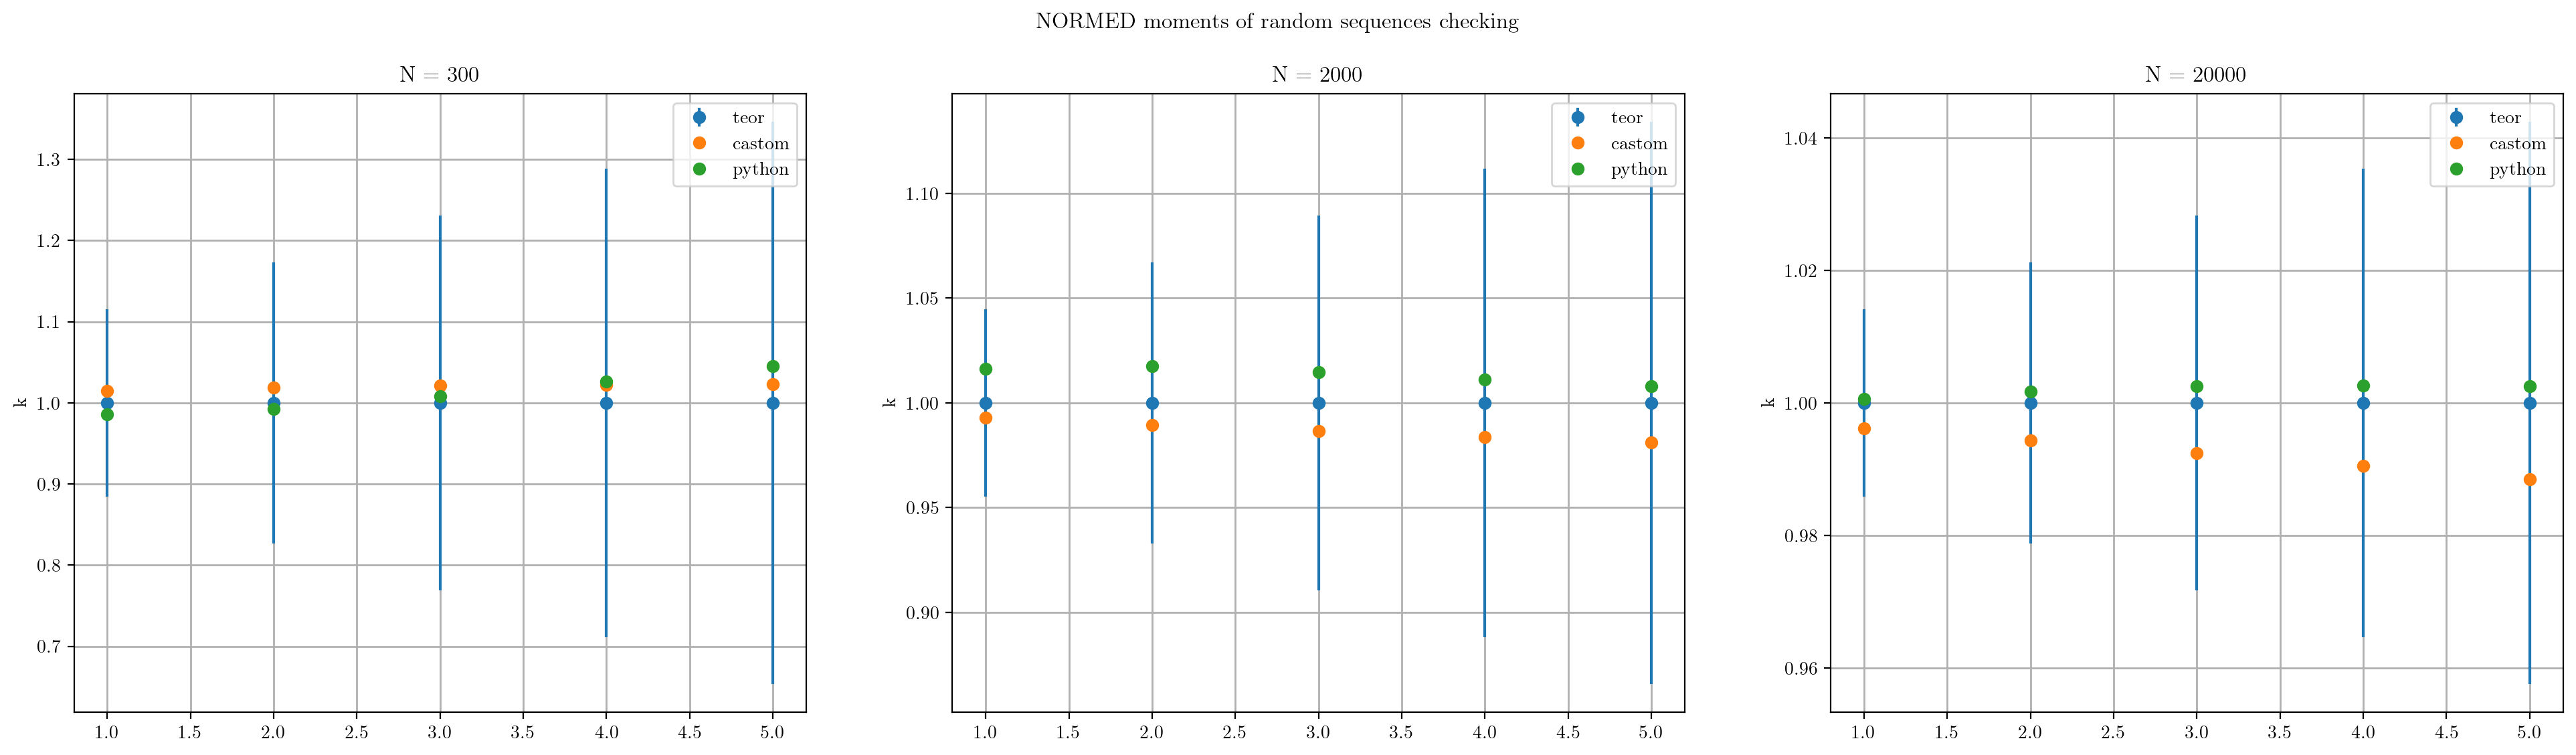

In [6]:
def generate_sequence(generator_fun, N=1000):
    x = []
    for _ in range(N):
        x.append(generator_fun())
    return np.array(x)

test_rand = MyRNG(a = 57, c = 1, m = 256)
test_rand.I = 0

import random
random.seed(42)

plt.figure(figsize=(8*3, 6))
plt.suptitle("NORMED moments of random sequences checking")

Ns = [300, 2000, 20_000]
for i in range(3):
    N = Ns[i]
    plt.subplot(1, 3, 1+i)
    plt.title(f"N = {N}")
    plt.ylabel("$<x^k>(k+1)$")
    plt.ylabel("k")
    k_s = list(range(1, 6))

    moments = []
    error = []
    for k in k_s:
        moments.append(1/(k+1))
        error.append(1/N**0.5)
    teor_moments = np.array(moments)
    plt.errorbar(k_s, np.ones_like(moments), fmt="o", yerr=error/teor_moments, label='teor')
        
    
    moments = []
    error = []
    rand_seq = generate_sequence(test_rand.rand, N=N)
    for k in k_s:
        x_k = rand_seq**k
        moments.append(np.mean(x_k))
        
        # standart deviation
        error.append(np.sqrt(np.mean(np.square(x_k.mean() - x_k))))  
    plt.errorbar(k_s, moments/teor_moments, fmt="o", label='castom')
        
        
    moments = []
    error = []
    rand_seq = generate_sequence(random.random, N=N)
    for k in k_s:
        x_k = rand_seq**k
        moments.append(np.mean(x_k))
        
        # standart deviation
        error.append(np.sqrt(np.mean(np.square(x_k.mean() - x_k))))  
    plt.errorbar(k_s, moments/teor_moments, fmt="o", label='python')
        
    plt.legend()    


So uniformity of this simple random generator is good enough at this scale

## 6b. A persistent random walk

#### i

In [ ]:
import random
random.seed(42)


rand_fun = random.random
def simulate_persistent_random_walk(a, N=1000):
    pos = 0
    step = 1    # consider first step to be positive
    for _ in range(N):
        if rand_fun() > a:
            step*= -1
        pos += step
    return pos
print(simulate_persistent_random_walk(0.75))

44


In [8]:
alpha = 0.75
M = 100
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N = 100))

final_xs = np.array(final_xs)
print(
f'''After 100 steps average position and it's dispersion are
<x> = {final_xs.mean()}
<dx^2> = {np.mean(np.square(final_xs - final_xs.mean()))}  
      ''')

After 100 steps average position and it's dispersion are
<x> = 2.2
<dx^2> = 258.03999999999996  
      


#### ii

$\alpha = 0.25$

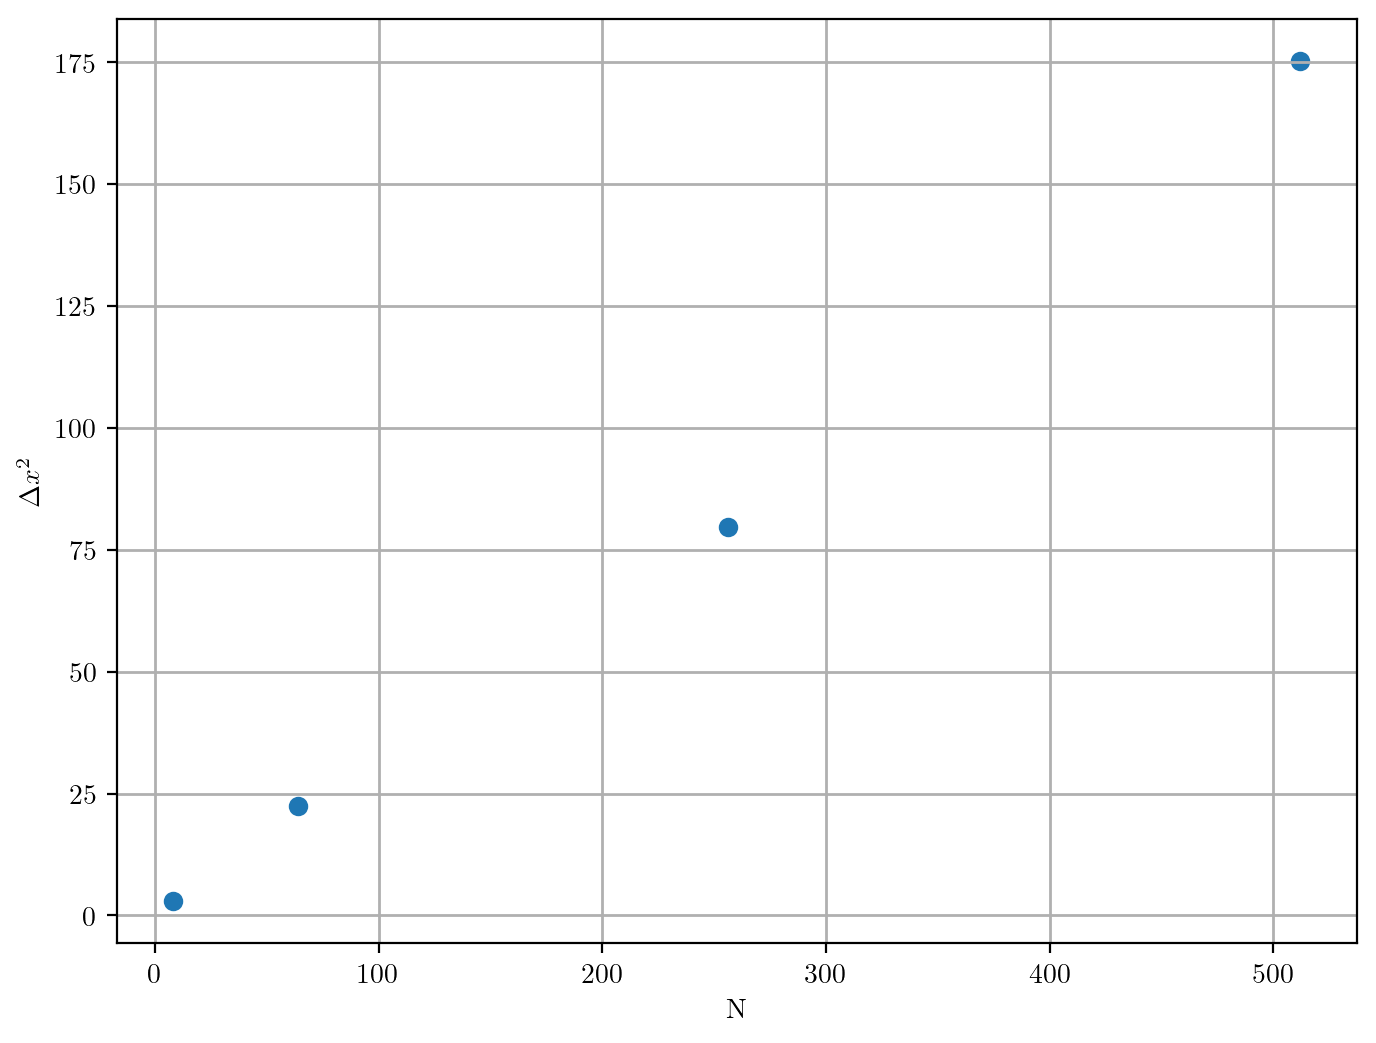

0.9758549675945628 +- 0.01821205396378023
-0.9673874932120413 +- 0.08700239326384746


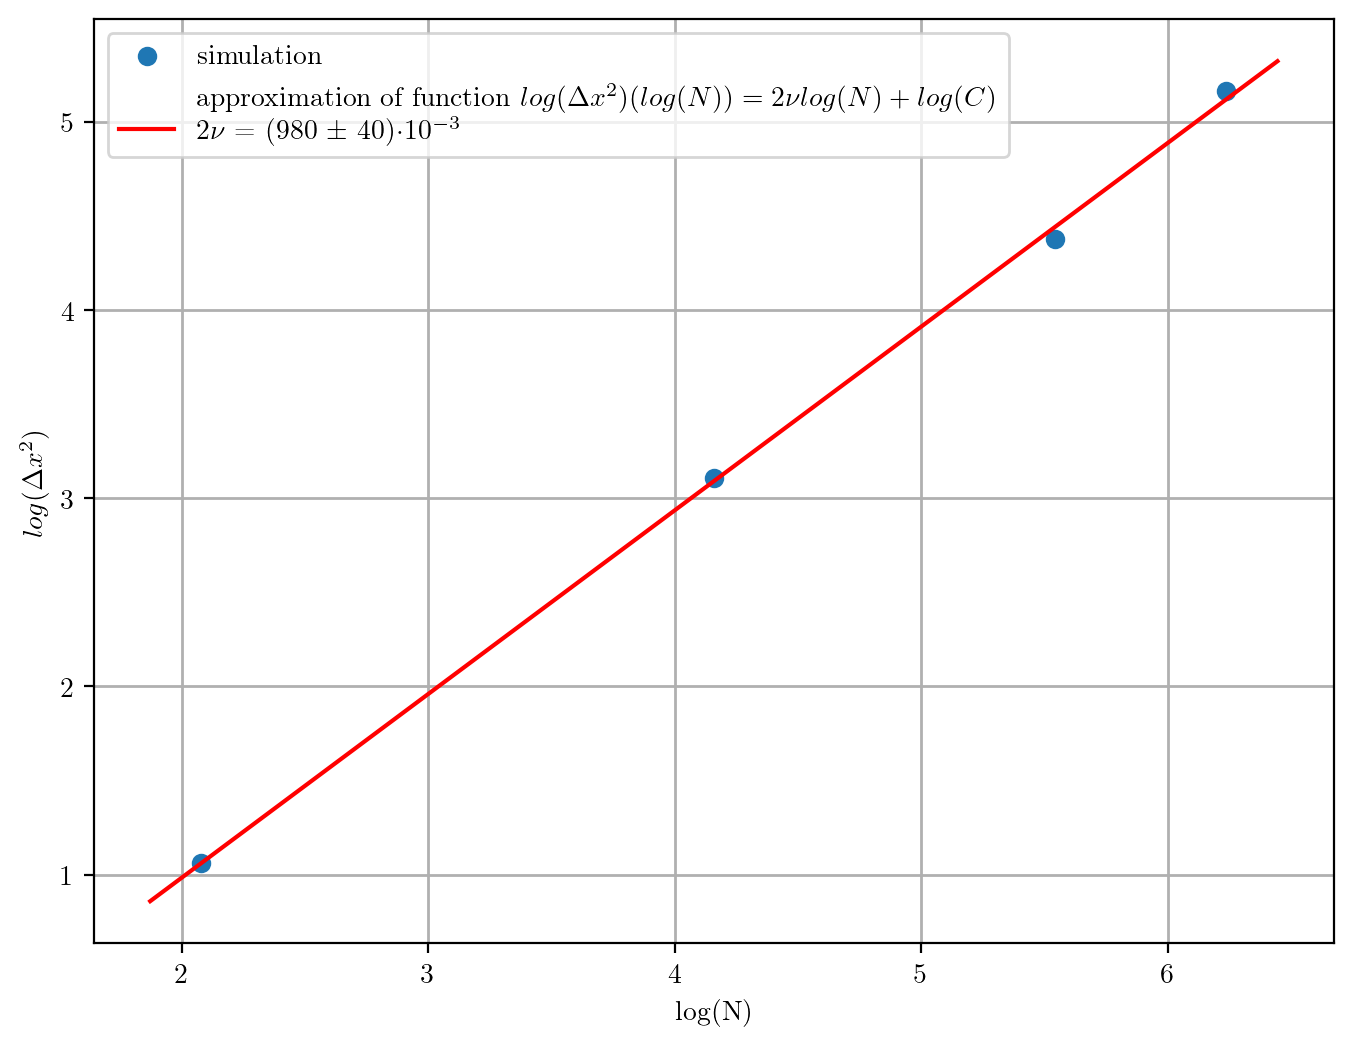

In [9]:
alpha = 0.25
Ns = np.array([8, 64, 256, 512])
M = 1000
dxs = []

for N in Ns:
    
    final_xs = []
    for _ in range(M):
        final_xs.append(simulate_persistent_random_walk(alpha, N=N))

    final_xs = np.array(final_xs)
    dx2 = np.mean(np.square(final_xs - final_xs.mean()))
    dxs.append(dx2)
    
dxs = np.array(dxs)
plt.scatter(Ns, dxs)
plt.xlabel("N")
plt.ylabel(r"$\Delta x^2$")
plt.show()

plt.scatter(np.log(Ns), np.log(dxs), label='simulation')
plt.xlabel("log(N)")
plt.ylabel(r"$log(\Delta x^2)$")


par_names_str = fr'''
$2\nu$, 
'''
# function to approximate
fun_name = r"$log(\Delta x^2)(log(N)) = 2\nu log(N) + log(C)$"
def f(x, k, b):
    return b + k * x

plot_approx(np.log(Ns), np.log(dxs), f, par_names_str, fun_name, visApproxError=False)
plt.legend()
plt.show()


$$ \nu \approx 0.49 \pm 0.2$$

$\alpha = 0.75$

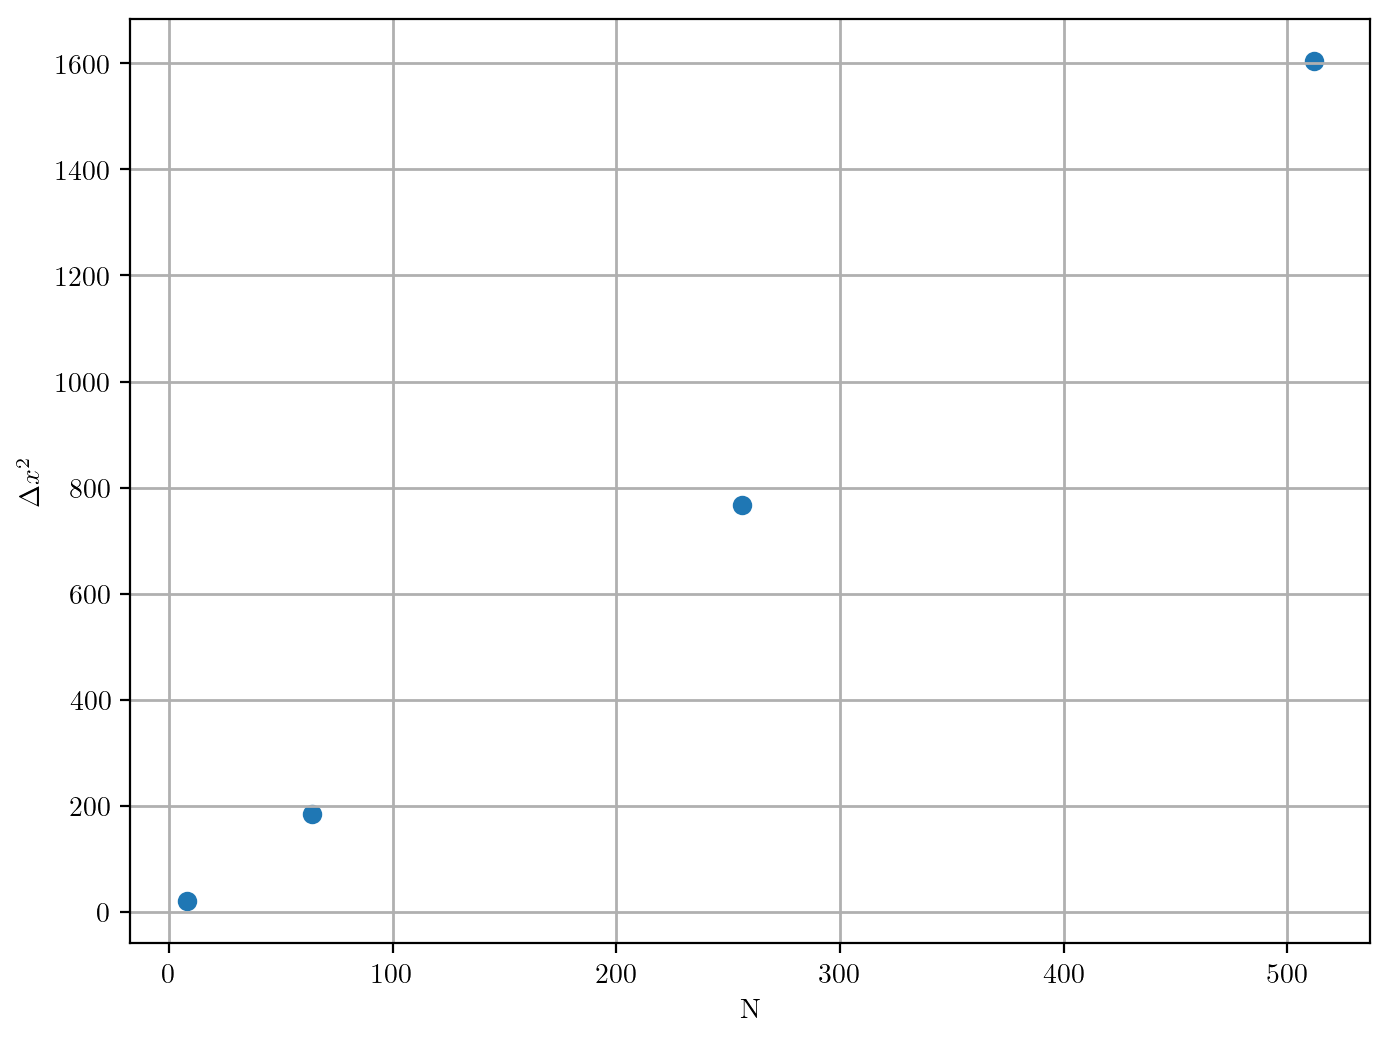

1.0524420709024278 +- 0.006070427366805373
0.8174467841369795 +- 0.028999568973004774


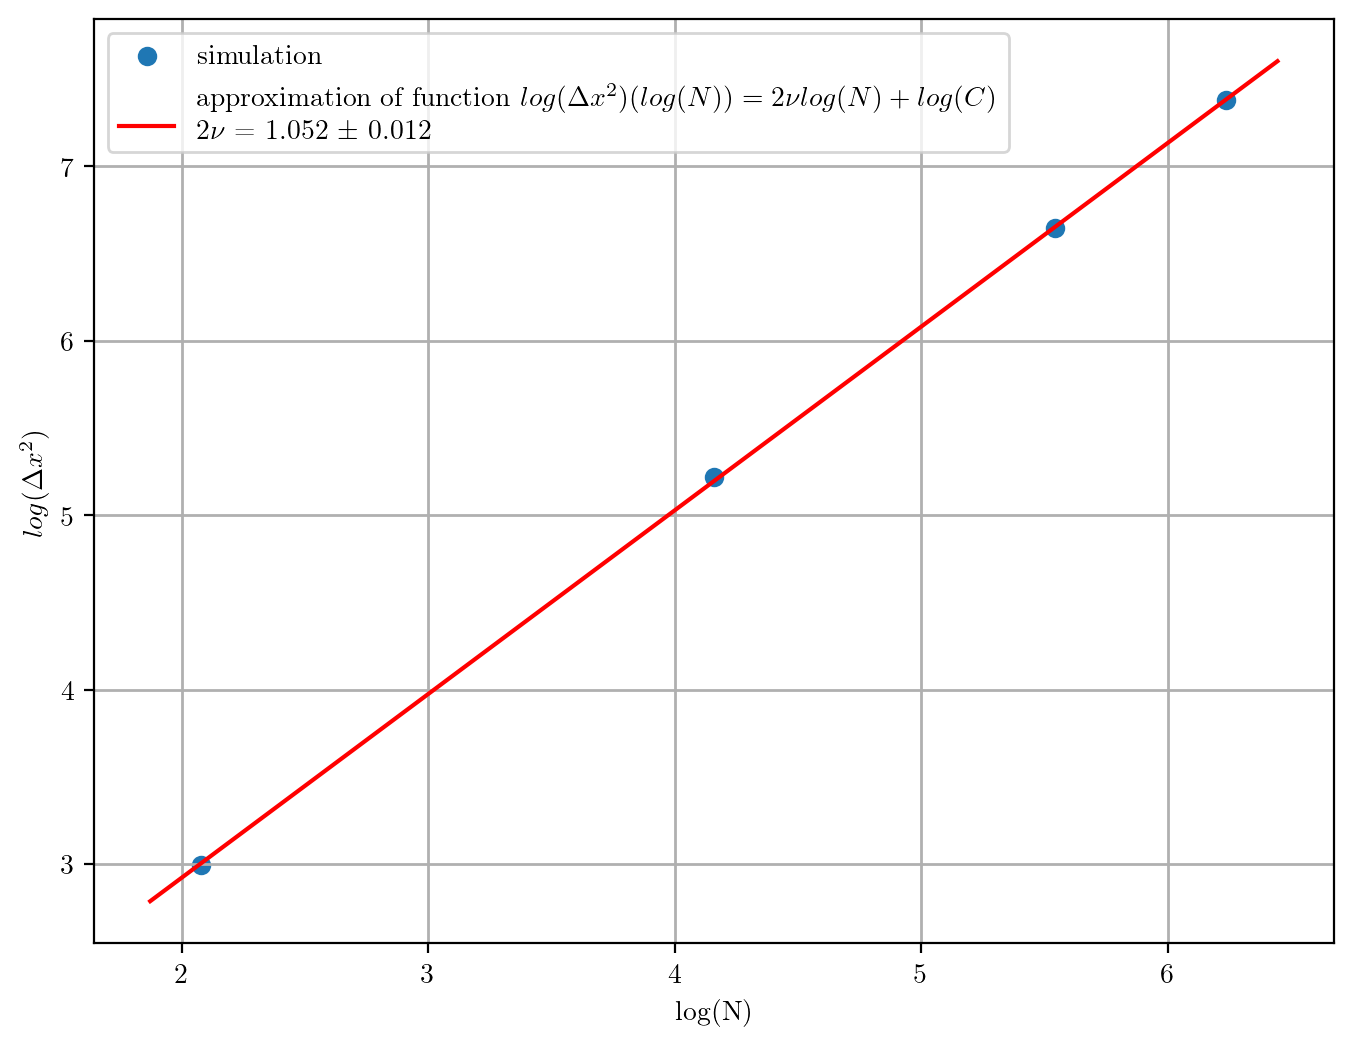

In [10]:
alpha = 0.75
Ns = np.array([8, 64, 256, 512])
M = 1000
dxs = []

for N in Ns:
    
    final_xs = []
    for _ in range(M):
        final_xs.append(simulate_persistent_random_walk(alpha, N=N))

    final_xs = np.array(final_xs)
    dx2 = np.mean(np.square(final_xs - final_xs.mean()))
    dxs.append(dx2)
    
dxs = np.array(dxs)
plt.scatter(Ns, dxs)
plt.xlabel("N")
plt.ylabel(r"$\Delta x^2$")
plt.show()

plt.scatter(np.log(Ns), np.log(dxs), label='simulation')
plt.xlabel("log(N)")
plt.ylabel(r"$log(\Delta x^2)$")


par_names_str = fr'''
$2\nu$, 
'''
# function to approximate
fun_name = r"$log(\Delta x^2)(log(N)) = 2\nu log(N) + log(C)$"
def f(x, k, b):
    return b + k * x

plot_approx(np.log(Ns), np.log(dxs), f, par_names_str, fun_name, visApproxError=False)
plt.legend()
plt.show()



$$ \nu \approx 0.53 \pm 0.1$$

It looks like even if $\nu$ depends on $\alpha$, it depends really slightly. 

#### D comparison

In [11]:
alpha = 0.5
M = 100_000
dxs = []
N = 1024
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N=N))

final_xs = np.array(final_xs)
dx2s = np.square(final_xs - final_xs.mean())
dx2 = np.mean(dx2s)
dxs.append(dx2)
dx_error = np.sqrt((np.mean(dx2s**2)-dx2s.mean()**2)/len(dx2s))


output = fr'''
for normal random walk ($\alpha = 0.5$)
$$ D \approx \frac{{1}}{{2d}}\frac{{\Delta x^2}}{{N}} \approx {dx2/N/2:.3f} \pm {dx_error/N/2:.3f}$$'''

alpha = 0.75
M = 100_000
dxs = []
N = 1024
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N=N))

final_xs = np.array(final_xs)
dx2s = np.square(final_xs - final_xs.mean())
dx2 = np.mean(dx2s)
dxs.append(dx2)
dx_error = np.sqrt((np.mean(dx2s**2)-dx2s.mean()**2)/len(dx2s))


output += fr'''
for $\alpha = {alpha}$
$$ D \approx \frac{{1}}{{2d}}\frac{{\Delta x^2}}{{N}} \approx {dx2/N/2:.3f} \pm {dx_error/N/2:.3f}$$'''

alpha = 0.25
M = 100_000
dxs = []
N = 1024
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N=N))

final_xs = np.array(final_xs)
dx2s = np.square(final_xs - final_xs.mean())
dx2 = np.mean(dx2s)
dxs.append(dx2)
dx_error = np.sqrt((np.mean(dx2s**2)-dx2s.mean()**2)/len(dx2s))


output += fr'''
for $\alpha = {alpha}$
$$ D \approx \frac{{1}}{{2d}}\frac{{\Delta x^2}}{{N}} \approx {dx2/N/2:.3f} \pm {dx_error/N/2:.3f}$$'''

print(output)


for normal random walk ($\alpha = 0.5$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.500 \pm 0.002$$
for $\alpha = 0.75$
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 1.504 \pm 0.007$$
for $\alpha = 0.25$
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.166 \pm 0.001$$


for normal random walk ($\alpha = 0.5$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.500 \pm 0.002$$
for $\alpha = 0.75$
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 1.504 \pm 0.007$$
for $\alpha = 0.25$
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.166 \pm 0.001$$

Experimentally,  dispresion coefficients for $\alpha \neq 0.5$ are smaller.

$\alpha < 0.5$  case is clear. When $\alpha \rightarrow 0$ direction is always changing, so the particle will stay near the origin and D will be really small.

For $\alpha > 0.5$ D is expected to be small, because in extream case, when $\alpha \rightarrow 1$ all steps are made in one direction, so $\Delta x^2 = 0$. Movement is fully determined.

If we try these extreme cases:

In [12]:

alpha = 0.0005
M = 10_000
dxs = []
N = 1024
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N=N))

final_xs = np.array(final_xs)
dx2s = np.square(final_xs - final_xs.mean())
dx2 = np.mean(dx2s)
dxs.append(dx2)
dx_error = np.sqrt((np.mean(dx2s**2)-dx2s.mean()**2)/len(dx2s))


output = fr'''
for normal random walk ($\alpha = {alpha}$)
$$ D \approx \frac{{1}}{{2d}}\frac{{\Delta x^2}}{{N}} \approx {dx2/N/2:.5f} \pm {dx_error/N/2:.5f}$$'''

print(output)


for normal random walk ($\alpha = 0.0005$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.00034 \pm 0.00001$$


for normal random walk ($\alpha = 0.0005$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 0.00034 \pm 0.00001$$


In [13]:

alpha = 1-0.0005
M = 10_000
dxs = []
N = 1024
final_xs = []
for _ in range(M):
    final_xs.append(simulate_persistent_random_walk(alpha, N=N))

final_xs = np.array(final_xs)
dx2s = np.square(final_xs - final_xs.mean())
dx2 = np.mean(dx2s)
dxs.append(dx2)
dx_error = np.sqrt((np.mean(dx2s**2)-dx2s.mean()**2)/len(dx2s))


output = fr'''
for normal random walk ($\alpha = {alpha}$)
$$ D \approx \frac{{1}}{{2d}}\frac{{\Delta x^2}}{{N}} \approx {dx2/N/2:.5f} \pm {dx_error/N/2:.5f}$$'''

print(output)


for normal random walk ($\alpha = 0.9995$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 176.10234 \pm 2.65858$$


for normal random walk ($\alpha = 0.9995$)
$$ D \approx \frac{1}{2d}\frac{\Delta x^2}{N} \approx 176 \pm 3$$


So, as we can see, with small $\alpha$ it works, but with big -- doesn't. probably because such rare cases, when particle turns around increase $\Delta x^2$ really good.